In [32]:
from itertools import cycle, islice
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pickle
from scipy.stats import gaussian_kde
import seaborn as sns
import re

from sklearn.decomposition import PCA

import importlib

import imnn
importlib.reload(imnn)
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

import torch
import torch.utils.data
from torchvision import datasets, transforms
#sns.set()

import toypipeline
importlib.reload(toypipeline)

LATENT_DIM = 30
DATA_DIM = 784

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")
OUTPUT = '/scratch/users/nmiolane/imoutput'

In [ ]:
DATA_PATH = ''

# Inspect Functions

In [25]:
algo_strings = {'vae': 'VAE', 'iwae': 'IWAE', 'vem': 'VIWAE'}
crit_strings = {'neg_elbo': 'Neg ELBO', 'neg_iwelbo': 'Neg IWELBO', 'neg_loglikelihood': 'NLL'}
train_val_strings = {'train': 'Train', 'val': 'Valid'}
crit_color_dict = {'neg_elbo': 'red', 'neg_iwelbo': 'orange'}
algo_color_dict = {'vae': 'red', 'iwae': 'orange', 'vem': 'blue'}

In [45]:
def plot_kl_posterior(ax, algo_name='vae', mode='train',
                      from_epoch=0, to_epoch=1000, color='blue', dashes=False):

    neg_elbo = get_losses(algo_name=algo_name, crit_name='neg_elbo', mode=mode)
    neg_ll = get_losses(algo_name=algo_name, crit_name='neg_loglikelihood', mode=mode)

    kl = [nelbo - nll for (nelbo, nll) in zip(neg_elbo, neg_ll)]
    
    n_epochs = len(kl)
    epochs = range(n_epochs)
    to_epoch = min(to_epoch, n_epochs)

    label = f'{algo_strings[algo_name]}: {train_val_strings[mode]} KL'
   
    if not dashes:
        ax.plot(epochs[from_epoch:to_epoch], kl[from_epoch:to_epoch], 
                label=label, color=color)
    else:
        ax.plot(epochs[from_epoch:to_epoch], kl[from_epoch:to_epoch], 
                label=label, color=color, dashes=[2, 2, 2, 2])
    ax.set_xlabel('epochs')
    return ax

In [46]:
def plot_kl_prior(ax, algo_name='vae', mode='train',
                  from_epoch=0, to_epoch=1000, color='blue', dashes=False):

    neg_elbo = get_losses(algo_name=algo_name, crit_name='neg_elbo', mode=mode)
    reconstruction_loss = get_losses(algo_name=algo_name, crit_name='reconstruction', mode=mode)

    kl = [nelbo - recon_loss for (nelbo, recon_loss) in zip(neg_elbo, reconstruction_loss)]
    
    n_epochs = len(kl)
    epochs = range(n_epochs)
    to_epoch = min(to_epoch, n_epochs)

    label = f'{algo_strings[algo_name]}: {train_val_strings[mode]} KL prior'
   
    if not dashes:
        ax.plot(epochs[from_epoch:to_epoch], kl[from_epoch:to_epoch], 
                label=label, color=color)
    else:
        ax.plot(epochs[from_epoch:to_epoch], kl[from_epoch:to_epoch], 
                label=label, color=color, dashes=[2, 2, 2, 2])
    ax.set_xlabel('epochs')
    return ax

In [47]:
def get_losses(algo_name='vae', crit_name='neg_elbo', mode='train'):
    losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/{mode}_losses.pkl')
    if len(losses_path) == 0:
        ckpts = glob.glob(f'{OUTPUT}/train_{algo_name}/models/epoch_*_checkpoint.pth')
        if len(ckpts) == 0:
            print(f'{algo_strings[algo_name]}: No {mode}_losses.pkl found. No checkpoints found.')
        else:
            ckpts_ids_and_paths = [(int(f.split('_')[2]), f) for f in ckpts]
            ckpt_id, ckpt_path = max(
                ckpts_ids_and_paths, key=lambda item: item[0])
            print('Found checkpoints. Getting: %s.' % ckpt_path)
            ckpt = torch.load(ckpt_path, map_location=DEVICE)
            
            losses = ckpt[f'{mode}_losses']
            losses = [loss[crit_name] for loss in losses]

    else:
        losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/{mode}_losses.pkl')[0]
        losses = pickle.load(open(losses_path, 'rb'))
        losses = [loss[crit_name] for loss in losses]
    return losses

In [48]:
def plot_criterion(ax, algo_name='vae', crit_name='neg_elbo', mode='train', 
                   from_epoch=0, to_epoch=1000, color='blue', dashes=False):
    if crit_name == 'kl_post':
        return plot_kl_posterior(
            ax=ax, algo_name=algo_name, mode=mode, 
            from_epoch=from_epoch, to_epoch=to_epoch, color=color, dashes=dashes)
    if crit_name == 'kl_prior':
        return plot_kl_prior(
            ax=ax, algo_name=algo_name, mode=mode, 
            from_epoch=from_epoch, to_epoch=to_epoch, color=color, dashes=dashes)
    
    losses_total = get_losses(algo_name=algo_name, crit_name=crit_name, mode=mode)
    
    n_epochs = len(losses_total)
    epochs = range(n_epochs)
    to_epoch = min(to_epoch, n_epochs)
    
    label = f'{algo_strings[algo_name]}: {train_val_strings[mode]} {crit_strings[crit_name]}'
   
    if not dashes:
        ax.plot(epochs[from_epoch:to_epoch], losses_total[from_epoch:to_epoch], 
                label=label, color=color)
    else:
        ax.plot(epochs[from_epoch:to_epoch], losses_total[from_epoch:to_epoch], 
                label=label, color=color, dashes=[2, 2, 2, 2])
    ax.set_xlabel('epochs')
    ax.legend()
    return ax

# Comparison of Convergences

In [26]:
from_epoch = 0
to_epoch = 60

IndexError: list index out of range

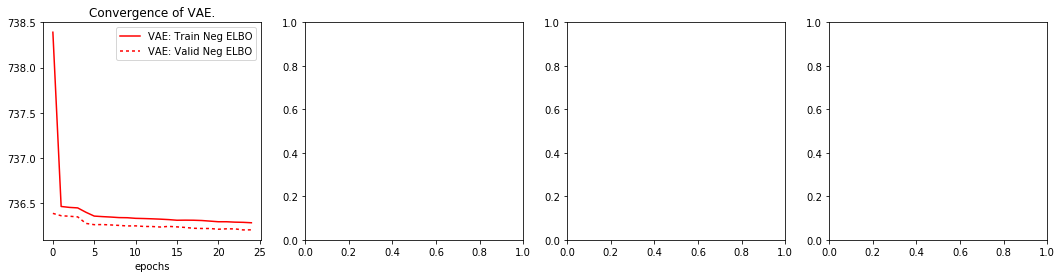

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

ax = axes[0]
ax = toyvis.plot_convergence(ax, OUTPUT, 'vae', 'neg_elbo')

ax = axes[1]
ax = toyvis.plot_convergence(ax, OUTPUT, 'iwae', 'neg_iwelbo')

ax = axes[2]
ax = toyvis.plot_convergence(ax, OUTPUT, 'vem', 'neg_elbo')
ax = axes[3]
ax = toyvis.plot_convergence(ax, OUTPUT, 'vem', 'neg_iwelbo')

NameError: name 'plot_kl' is not defined

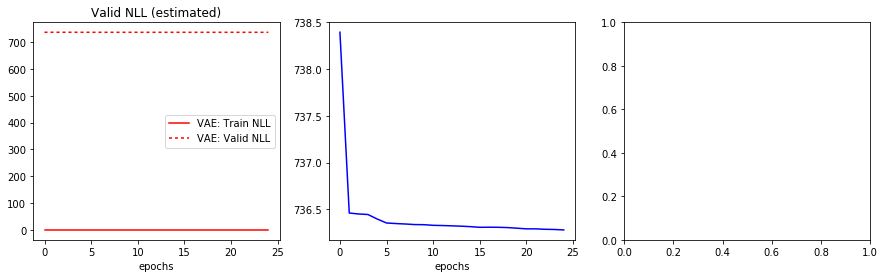

In [28]:
def plot_kl_prior_all(ax, algo_name):
    # ax = plot_kl_posterior(ax, algo_name=algo_name, mode='train',
    #                   from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name], dashes=False)
    ax = plot_criterion(ax, algo_name=algo_name, crit_name='kl_prior', mode='val',
                      from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name], dashes=True)
    
    return ax

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

ax = axes[0]
ax = toyvis.plot_nll(ax, OUTPUT, 'vae')
#ax = plot_nll(ax, 'iwae')
#ax = plot_nll(ax, 'vem')
ax.set_title('Valid NLL (estimated)')

ax = axes[1]
ax = toyvis.plot_kl_posterior_bis(ax, OUTPUT, 'vae')
ax = plot_kl(ax, 'iwae')
ax = plot_kl(ax, 'vem')
ax.set_title('Valid KL to posterior (estimated)')
ax.legend()

ax = axes[2]
ax = plot_kl_prior_all(ax, 'vae')
ax = plot_kl_prior_all(ax, 'iwae')
ax = plot_kl_prior_all(ax, 'vem')
ax.set_title('Valid KL to prior (estimated)')
ax.legend()

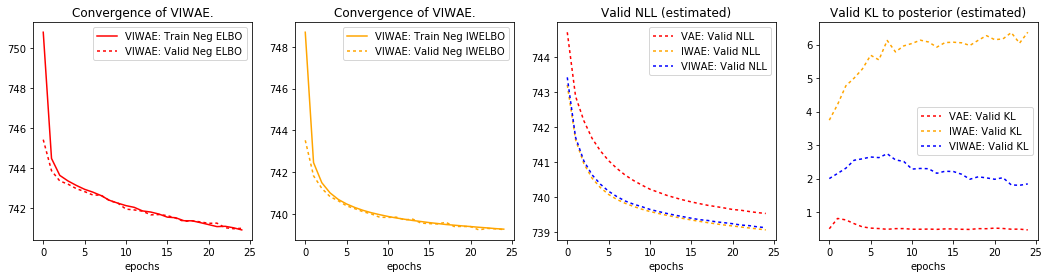

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

ax = axes[0]
ax = plot_convergence(ax, 'vem', 'neg_elbo')
ax = axes[1]
ax = plot_convergence(ax, 'vem', 'neg_iwelbo')

ax = axes[2]
ax = plot_nll(ax, 'vae')
ax = plot_nll(ax, 'iwae')
ax = plot_nll(ax, 'vem')
ax.set_title('Valid NLL (estimated)')

ax = axes[3]
ax = plot_kl(ax, 'vae')
ax = plot_kl(ax, 'iwae')
ax = plot_kl(ax, 'vem')
ax.set_title('Valid KL to posterior (estimated)')
ax.legend()

# Inspect latent spaces

In [29]:
m = toyvis.load_module(OUTPUT)
print(m)

Loading: /scratch/users/nmiolane/imoutput/train_vae/models/encoder.pth
Encoder(
  (fc1): Linear(in_features=784, out_features=900, bias=True)
  (fc21): Linear(in_features=900, out_features=30, bias=True)
  (fc22): Linear(in_features=900, out_features=30, bias=True)
)


In [12]:
def latent_space_pca(val_dataset, n_components, algo_name='vae'):
    encoder = load_module(algo_name, 'encoder')

    mus = []
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, **KWARGS)
    for i, data in enumerate(val_loader):
        data = data[0].to(DEVICE)
        data = data.view(-1, 784)
        mu, logvar = encoder(data)
        mu = np.array(mu.cpu().detach())
        mus.append(mu)

    mus = np.vstack(mus).squeeze()

    pca = PCA(n_components=n_components)
    pca.fit(mus)
    projected_mus = pca.transform(mus)
    return projected_mus

In [13]:
def plot_pca(ax, val_dataset, algo_name='vae'):
    projected_mus = latent_space_pca(val_dataset, n_components=2, algo_name=algo_name)
    val_labels = val_dataset.test_labels
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                      '#999999', '#e41a1c', '#dede00']),
                                      int(max(val_labels) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    sc = ax.scatter(projected_mus[:, 0], projected_mus[:, 1], s=10, color=colors[val_labels])
    #legend = ax.legend(*sc.legend_elements(), title='Labels')
    #ax.add_artist(legend)
    #ax.legend()
    ax.set_title(algo_strings[algo_name])
    return ax

NameError: name 'load_module' is not defined

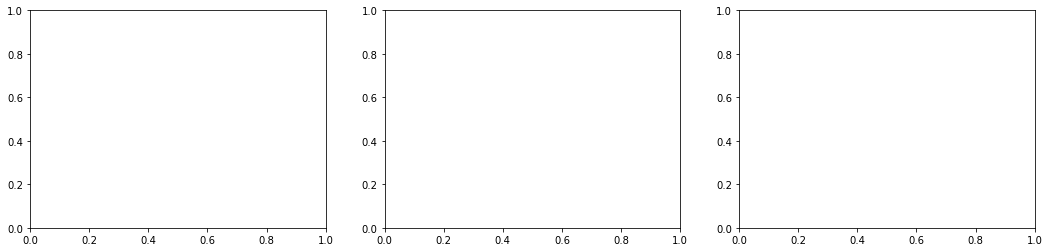

In [30]:
BATCH_SIZE = 32
KWARGS = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

test_dataset = datasets.MNIST(
    '../data', download=True, train=False, transform=transforms.ToTensor())


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax = axes[0]
ax = plot_pca(ax, test_dataset, 'vae')

ax = axes[1]
ax = plot_pca(ax, test_dataset, 'iwae')

ax = axes[2]
ax = plot_pca(ax, test_dataset, 'vem')

# Inspect active units

Loading: /scratch/users/nmiolane/imoutput/train_vae/models/decoder.pth


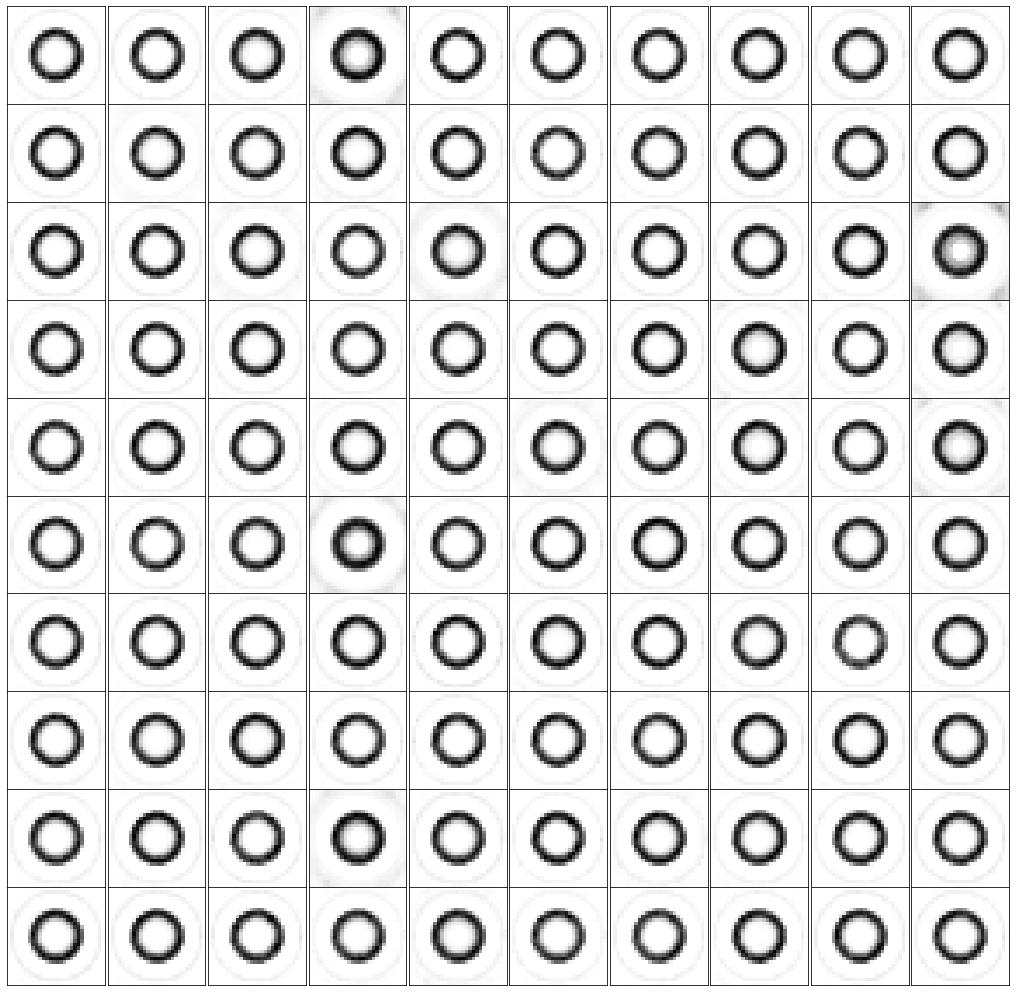

In [33]:
fig = plt.figure(figsize=(18, 18))
outer = gridspec.GridSpec(1, 1, wspace=0.1, hspace=0.1)

for i, algo_name in enumerate(['vae']):
    toyvis.show_samples(OUTPUT, fig, outer, i, algo_name, latent_dim=LATENT_DIM, data_dim=DATA_DIM, cmap='Greys')
fig.show()

# Comparison of times

In [241]:
def print_average_time(algo_name='vae'):
    losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/train_losses.pkl')[0]
    losses_all_epochs = pickle.load(open(losses_path, 'rb'))
    
    times = [loss['total_time'] for loss in losses_all_epochs]
    print(np.mean(times))
    
print_average_time('vae')
print_average_time('iwae')
print_average_time('vem')

8.604231262207032
12.053642284870147
19.189127266407013


# Print pipeline logs

In [39]:
pattern = 'logs'
logs = []
for filename in os.listdir(OUTPUT):
    if re.search(pattern, filename):
        logs.append(filename)

print('Found %d log files.' % len(logs))
        
for filename in logs:
    path = os.path.join(OUTPUT, filename)
    print('\n-- Log file: %s\n' % filename)
    with open(path, 'r') as f:
        message = f.read()
    print(message)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/nmiolane/imoutput_nips_mnist10'